# Анализ оттока клиентов
В рамках данного проекта разработаем модель прогнозирования оттока клиентов "Бета-Банка". Фактом оттока считается расторжение договора предоставления банковских услуг клинетом. Целевая метрика f1 (совместная оценка точности и полноты прогноза) - не ниже **0.59**

#### Оглавление<a id="0"></a>

- [Загрузка данных](#1)   
    - [Обзор данных](#1.1)    
- [Подготовка данных](#2)   
- [Обучение](#3)   
    - [Работа с "сырыми" моделями](#3.1)
    - [Устранение дисбаланса](#3.2)
    - [Подбор гипер-параметров](#3.3)
        - [Logistic Regression](#3.3.1)
        - [Decision Tree](#3.3.2)
        - [Random Forest](#3.3.3)        
    - [Сравнение ROC AUC](#3.4)  
- [Тестирование](#4)
- [Заключение](#5)

В нашем распоряжении выборка данных о 10 тысячах клиентов. Таблица содержит следующие столбцы:   

Административные данные:   
- `RowNumber` — индекс строки в данных  
- `CustomerId` — уникальный идентификатор клиента  
- `Surname` — фамилия  

Признаки:   
- `CreditScore` — кредитный рейтинг  
- `Geography` — страна проживания  
- `Gender` — пол  
- `Age` — возраст  
- `Tenure` — сколько лет человек является клиентом банка  
- `Balance` — баланс на счёте  
- `NumOfProducts` — количество продуктов банка, используемых клиентом  
- `HasCrCard` — наличие кредитной карты  
- `IsActiveMember` — активность клиента  
- `EstimatedSalary` — предполагаемая зарплата  


Целевой признак:  
- `Exited` — факт ухода клиента    

Подготовим необходимые для работы библиотеки и установим настройки.

In [3]:
# %%capture
!pip install -U tqdm
# !pip install -U seaborn

     -------------------------------------- 78.5/78.5 kB 487.3 kB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.1, style='darkgrid')

from tqdm import tqdm
import operator
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

c = 'Blues' # colormap
rs = 100 # random state

### Загрузка и обзор данных<a id="1"></a>
Загрузим таблицу и изучим её состав. 

In [7]:
df = pd.read_csv('Churn.csv')

display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<a id="1.1"></a>

Два категориальных признака представлены в строковом формате. Далее мы закодируем их для построения модели прогнозирования.  Также в колонке "Tenure" (длительность пользования услугами) есть пропущенные значения.    

Изучим как распределены признаки в датасете (исключим административные колонки и целевой признак).

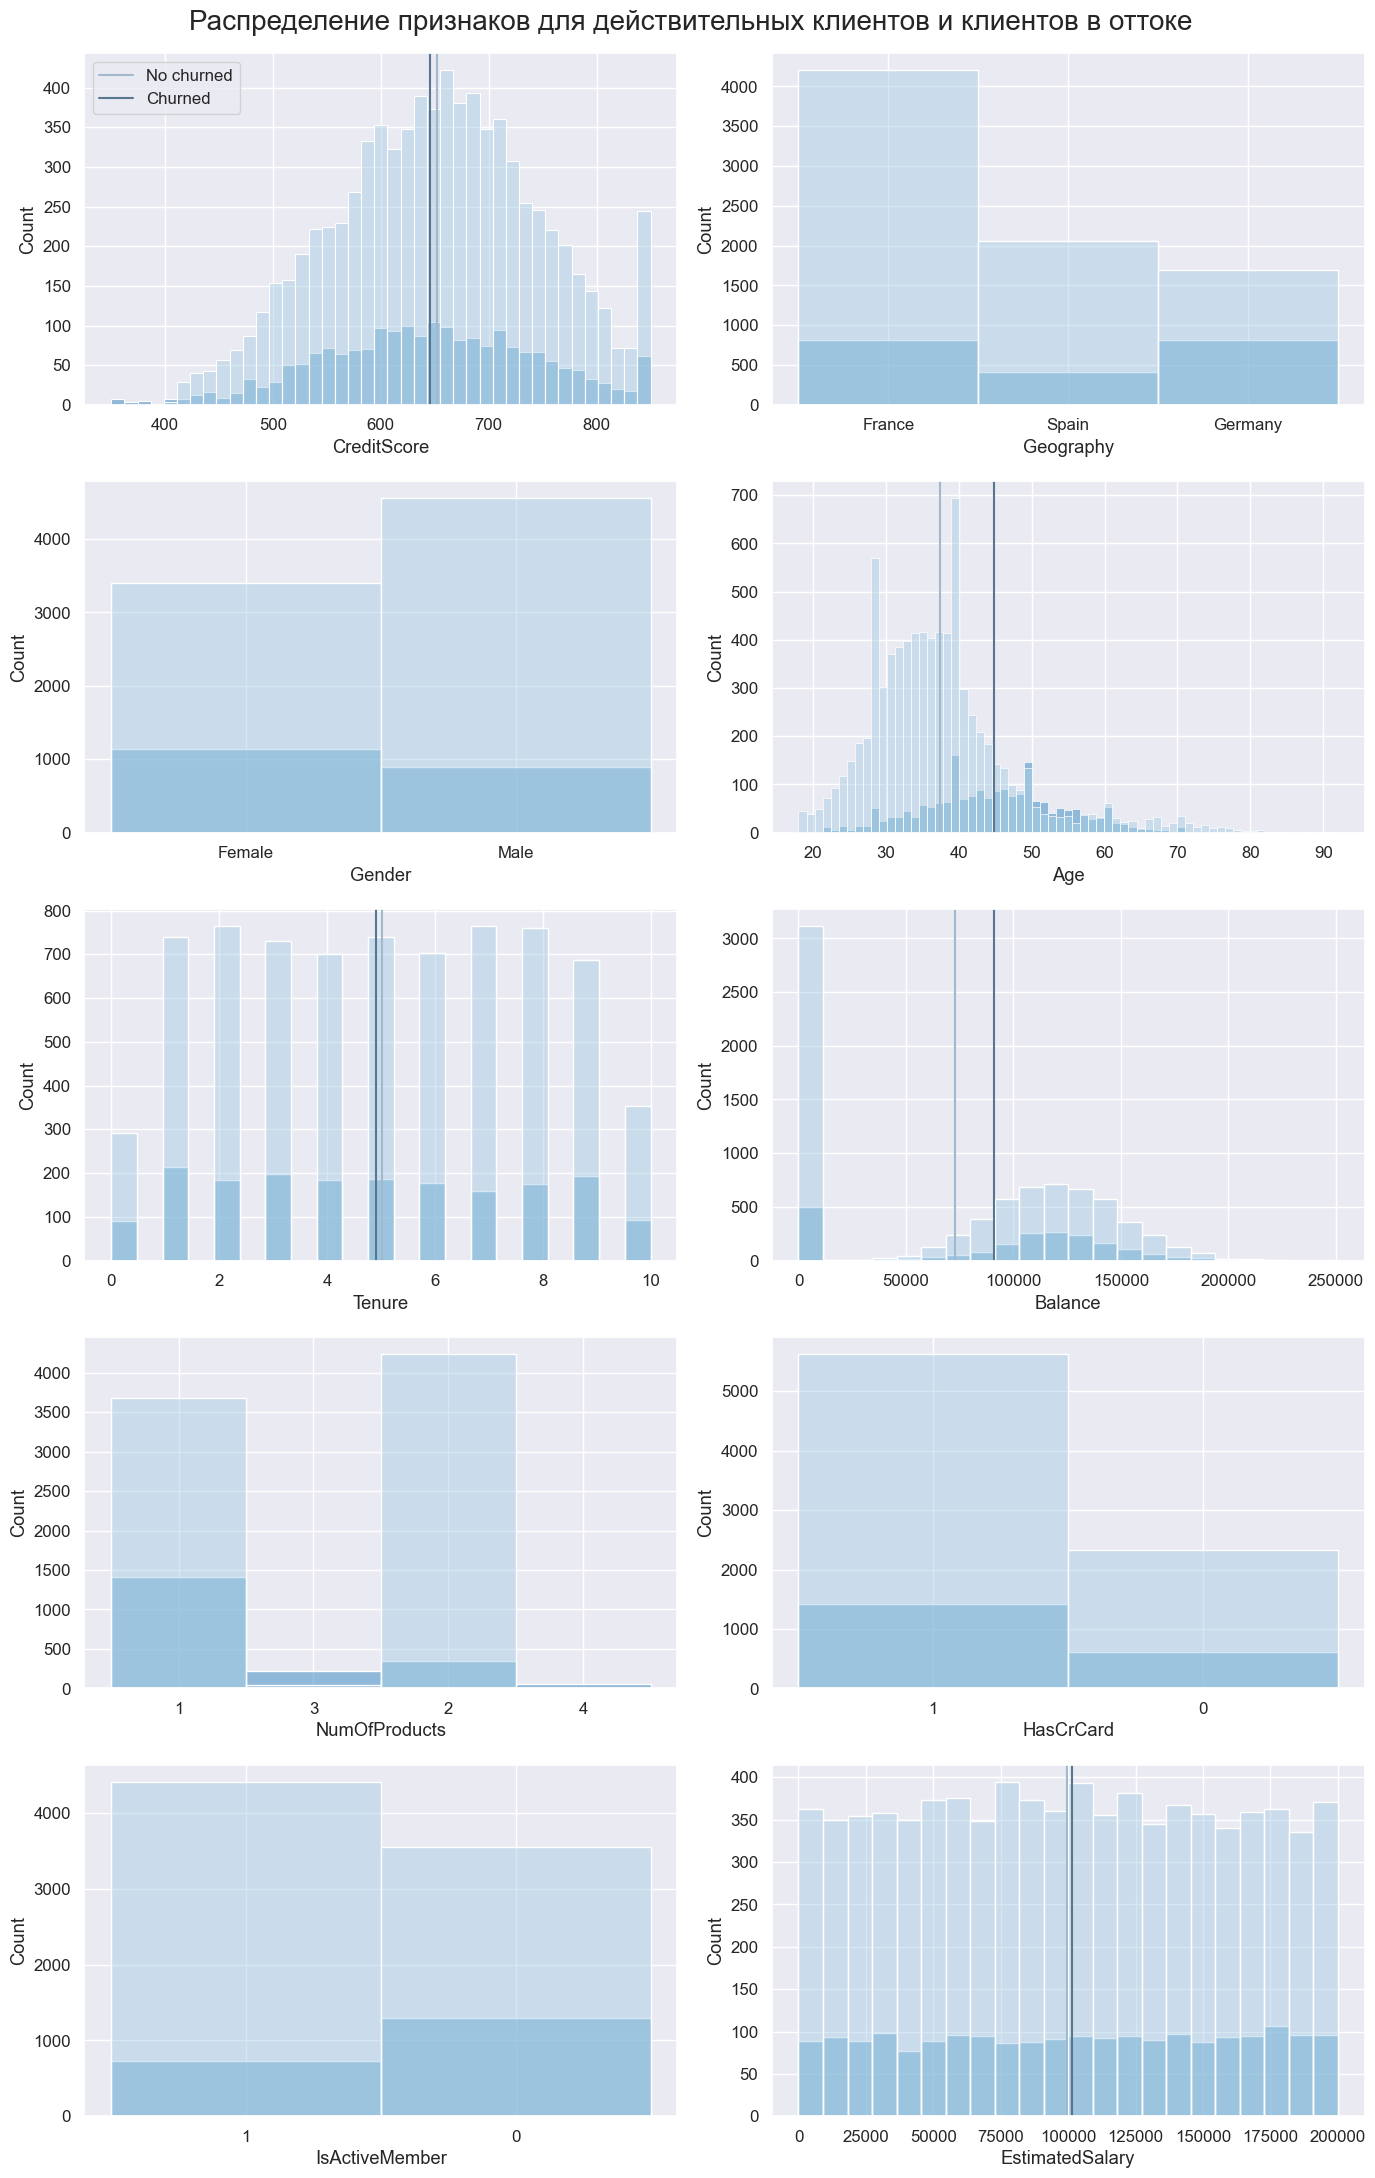

In [8]:
data_overview = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
data_overview['NumOfProducts'] = data_overview['NumOfProducts'].astype('str')
data_overview['HasCrCard'] = data_overview['HasCrCard'].astype('str')
data_overview['IsActiveMember'] = data_overview['IsActiveMember'].astype('str')
grid =  [(i, j) for i in range(5) for j in range(2)]

fig, ax = plt.subplots(5, 2, figsize=(14, 22))

for position, column in zip(grid, data_overview):
    sns.histplot(data=data_overview, x=column, ax=ax[position], hue='Exited', legend=False, alpha=.5, palette=c)
    try:
        mean1 = data_overview[data_overview['Exited'] != 1][column].mean()
        mean2 = data_overview[data_overview['Exited'] == 1][column].mean()
        ax[position].axvline(mean1, c='#a1b9cc')
        ax[position].axvline(mean2, c='#59768f')
    except:
        pass

ax[0, 0].legend(['No churned', 'Churned'], loc=2, fancybox=True)

plt.suptitle('Распределение признаков для действительных клиентов и клиентов в оттоке', fontsize=20, y=.99)
plt.tight_layout()
plt.show()
plt.close()

Наибольшая разница средних значений между клиентами попаышими в отток и оставшимися наблюдается в категориях "Balance" (баланс счёта) и "Age" (возраст). Также образщает на себя внимание, что доля оттока среди клиентов, пользующихся двумя услугами меньше, чем одной услугой (при том, что общее количество пользователей двух услуг больше). Также доля ушедших клиентов в Германии больше, чем, например, в Испании.   

Проверим корреляции между признаками.  

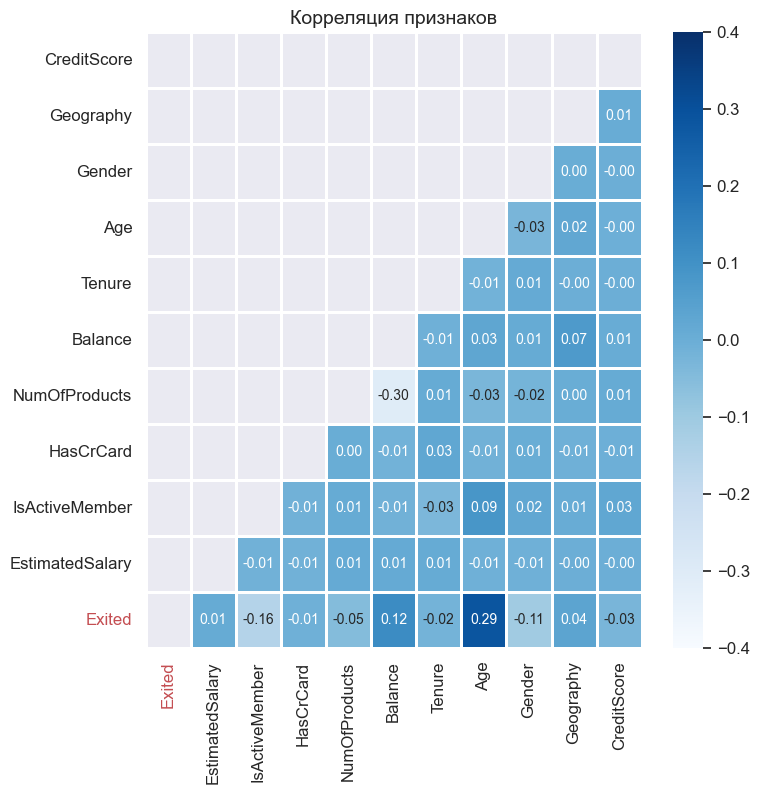

In [9]:
data_correlations = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
encoded_columns = OrdinalEncoder().fit_transform(df[['Geography', 'Gender']])
data_correlations['Geography'] = encoded_columns[:, 0]
data_correlations['Gender'] = encoded_columns[:, 1]

plt.figure(figsize=(8, 8))

corr = data_correlations.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

ax = sns.heatmap(corr, linewidths=2, annot=True, mask=mask,
                 annot_kws={'size': 10}, fmt='.2f', vmin=-.4,  vmax=.4, cmap=c)
ax.invert_xaxis()
ax.xaxis.get_ticklabels()[10].set_color('r')
ax.yaxis.get_ticklabels()[10].set_color('r')

plt.title('Корреляция признаков', fontsize=14)
plt.show()
plt.close()

Целевой признак оттока слабо коррелирует с возрастом клиентов. Однако, наблюдемый коэффициент корреляции недостаточен, чтобы считать отток связанным с возрастом.    




- [К оглавлению](#0)    

### Подготовка данных<a id="2"></a>
Выберем признаки, на основе которых будем проводить исследование. В колонке "Tenure" (длительность пользования услугами) заменим отсутствующие значения на `-1`

In [10]:
Xy_raw = df.loc[:, 'CreditScore': 'Exited']
Xy_raw['Tenure'] = Xy_raw['Tenure'].fillna(-1)

Так как колонки 'Geography' и 'Gender' содержат категориальные значения, преобразуем их методом прямого кодирования в бинарные значения.

In [11]:
Xy_raw = Xy_raw.join(pd.get_dummies(Xy_raw[['Geography', 'Gender']], drop_first=True)).drop(columns={'Geography', 'Gender'})

Разделим выборку на обучающую, валидационную и тестовую в пропорциях 3/1/1, и проверим размерность получившихся наборов данных.

In [12]:
split_20_percent = int(len(Xy_raw) * .2)
test, val, train = np.split(Xy_raw.sample(frac=1, random_state=rs), [split_20_percent, split_20_percent * 2])

ex = 'Exited'
X_train = train.drop(columns={ex})
X_val = val.drop(columns={ex})
X_test = test.drop(columns={ex})
y_train = train[ex]
y_test = test[ex]
y_val = val[ex]

print('Размер подвыборок:')
display(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_test.shape, y_val.shape)

Размер подвыборок:


(6000, 11)

(2000, 11)

(2000, 11)

(6000,)

(2000,)

(2000,)

Cтандартизируем численные признаки и проверим результат.

In [13]:
standart_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(X_train[standart_columns])

X_train[standart_columns] = scaler.transform(X_train[standart_columns])
X_val[standart_columns] = scaler.transform(X_val[standart_columns])
X_test[standart_columns] = scaler.transform(X_test[standart_columns])

Данные стандартизированы. Выборка разделена в нужных пропорциях. Ни один признак не потерялся.   



- [К оглавлению](#0)    

### Обучение<a id="3"></a>

#### Работа с сырыми моделями и данными<a id="3.1"></a>
Напишем функции для обучения, предсказания и измерения f1 для трёх моделей: Логистической регрессии, Дерева решений и Случайного леса.

In [14]:
def model_tune(model='RandomForest', X=X_val, y=y_val, X_train=X_train, y_train=y_train,
               nest=100, depth=None, min_leaf=1, threshold=.5):
    if model == 'RandomForest':
        model = RandomForestClassifier( n_estimators=nest, max_depth=depth, random_state=rs )
    if model == 'DecisionTree':
        model = DecisionTreeClassifier( max_depth=depth, min_samples_leaf=min_leaf, random_state=rs )
    if model == 'LogisticRegression':
        model = LogisticRegression( solver='liblinear', random_state=rs )    
        
    model.fit(X_train, y_train)
    y_predict = model.predict(X)
    f1 = f1_score(y, y_predict)    
    proba = model.predict_proba(X)[:, 1]
    corrected_predictions = proba > threshold
    f1_proba = f1_score(y, corrected_predictions)      
    
    
    return {'predictions': y_predict, 'probabilities': proba,
            'corrected_predictions': corrected_predictions,
            'f1': f1, 'f1_corrected':  f1_proba}

In [15]:
print(f"f1 модели:  {model_tune('LogisticRegression')['f1']}")

f1 модели:  0.33212996389891697


In [16]:
print(f"f1 модели:  {model_tune('DecisionTree')['f1']}")

f1 модели:  0.5245901639344261


In [17]:
print(f"f1 модели:  {model_tune('RandomForest')['f1']}")

f1 модели:  0.5934718100890207


Даже на неподготовленной модели Random Forest метрика f1 близка к целевой. 

#### Устранение дисбаланса<a id="3.2"></a>
Положительный класс во всей выборке встречается в 4 раза реже:

In [18]:
Xy_raw['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

В такой же пропорции положительный класс распределён в тренировочной выборке:

In [19]:
y_train.value_counts(normalize=True)

0    0.797333
1    0.202667
Name: Exited, dtype: float64

##### Upsampling
Дисбаланс выборки устраним с помощью досемплирования.

In [20]:
X_0 = X_train[y_train == 0]
X_1 = X_train[y_train == 1]
y_0 = y_train[y_train == 0]
y_1 = y_train[y_train == 1]

repeat = int(y_train.value_counts(normalize=True)[0] / y_train.value_counts(normalize=True)[1])

X_train, y_train = (shuffle(pd.concat([X_0] + [X_1] * repeat),
                            pd.concat([y_0] + [y_1] * repeat), random_state=rs))

In [21]:
print("Преобразованные данные:")
print(y_train.value_counts(normalize=True))
print(f"{len(y_train)} записей")

Преобразованные данные:
0    0.567362
1    0.432638
Name: Exited, dtype: float64
8432 записей


В результате апсемплинга количество записей увеличилось на ~2,5 тысячи. Баланс классов составляет 57/43.     

##### Downsampling
Также, в качестве альтернативного метода борьбы с дисбалансом, проведём даунсэмплинг. Эти подвыборки пригодятся позже.

In [22]:
fraction_coef = len(y_1) / len(y_0)
X_train_d = pd.concat([X_0.sample(frac=fraction_coef, random_state=rs)] + [X_1])
y_train_d = pd.concat([y_0.sample(frac=fraction_coef, random_state=rs)] + [y_1])
X_train_d, y_train_d = shuffle(X_train_d, y_train_d, random_state=rs)

print("Преобразованные данные:")
print(y_train_d.value_counts(normalize=True))
print(f"{len(y_train_d)} записей")

Преобразованные данные:
0    0.5
1    0.5
Name: Exited, dtype: float64
2432 записей


- [К оглавлению](#0)  

#### Подбор гиперпараметров на досэмплированной выборке<a id="3.3"></a>
Выберем и настроим модель на сбалансированных данных

##### Logistic Regression<a id="3.3.1"></a>

In [23]:
logreg_plot_data = {i: model_tune('LogisticRegression', threshold=i)['f1_corrected'] for i in np.arange(0, 0.65, 0.025)}

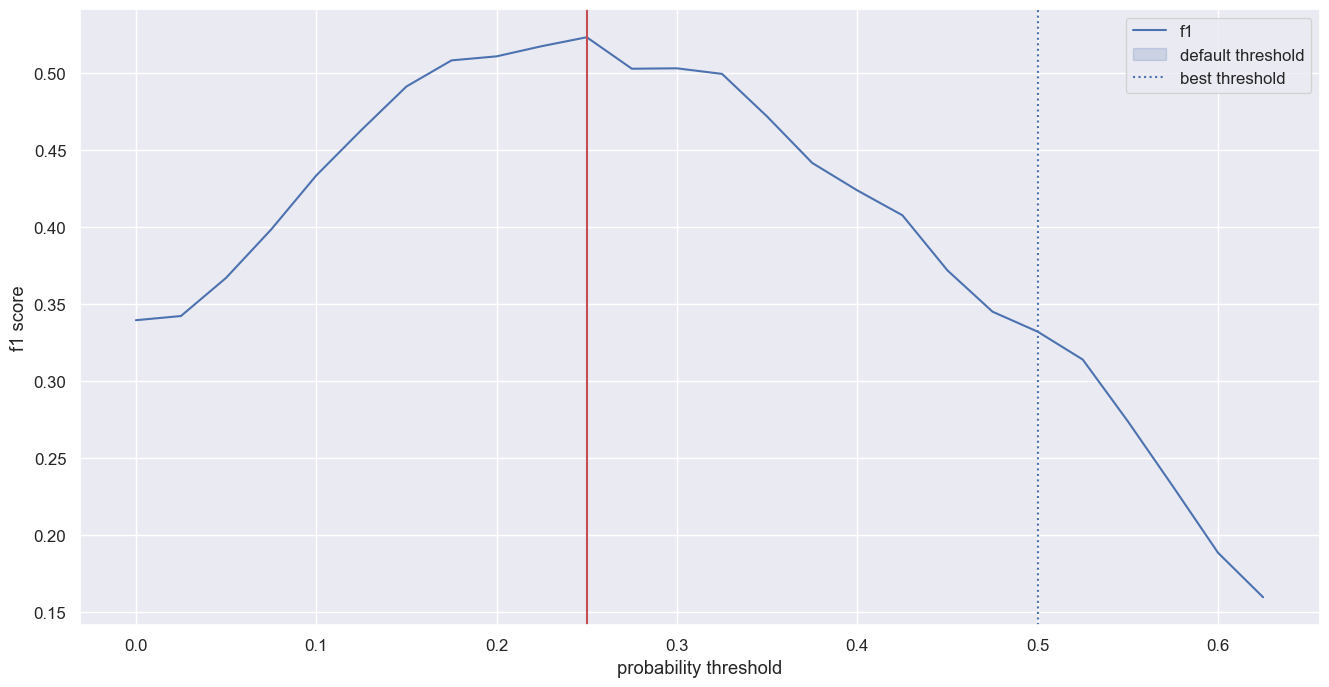

Лучший f1 score 0.523 при пороге 0.250


In [24]:
fig, ax = plt.subplots(figsize=(16, 8))

ax = sns.lineplot(x=logreg_plot_data.keys(), y=logreg_plot_data.values())
best_threshold = max(logreg_plot_data.items(), key=operator.itemgetter(1))

plt.axvline(.5, ls=':')
plt.axvline(best_threshold[0], c='r')
plt.xlabel('probability threshold')
plt.ylabel('f1 score')
plt.legend(['f1', 'default threshold', 'best threshold'])
plt.show()
plt.close()
print(f"Лучший f1 score {best_threshold[1]:.3f} при пороге {best_threshold[0]:.3f}")

**f1** Логистической регрессии значительно увеличилось, но всё равно не дотягивает до заданного уровня. 

##### Decision Tree Classifier<a id="3.3.2"></a>
Подберём гиперпараметры для дерева решений на основе сбалансированной выборки.

In [25]:
dec_tree_min_leaf = []
dec_tree_depth = []
dec_tree_threshold = []
dec_tree_f1 = []

for leafs in tqdm(range(10, 105, 5)):
    for depth in range(1, 21):
        for threshold in np.arange(0.2, 0.825, 0.025):
            dec_tree_min_leaf.append(leafs)
            dec_tree_depth.append(depth)
            dec_tree_threshold.append(threshold)
            dec_tree_f1.append(model_tune('DecisionTree', min_leaf=leafs,
                                          depth=depth, threshold=threshold)['f1_corrected'])

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [06:15<00:00, 19.77s/it]


In [36]:
dec_tree_data = (pd.DataFrame({'min_leaf': dec_tree_min_leaf, 'depth': dec_tree_depth,
                              'threshold': dec_tree_threshold, 'f1': dec_tree_f1})
                 .sort_values(by='f1', ascending=False)
                 .reset_index(drop=True))

dec_tree_data.head(10).style.apply(lambda x:
                                   ['background-color: orange'] * 4
                                   if x['f1'] == dec_tree_data['f1'].max()
                                   else None, axis=1)

,min_leaf,depth,threshold,f1
0,25,8,0.350000,0.645390
1,25,8,0.375000,0.645314
2,30,8,0.375000,0.645314
3,30,8,0.350000,0.645314
4,30,9,0.350000,0.642353
5,35,8,0.350000,0.641827
6,35,8,0.375000,0.641827
7,25,8,0.400000,0.640777
8,30,8,0.400000,0.640777
9,35,9,0.350000,0.639906


Наибольший f1 `0.64` достигается при гиперпараметрах `depth=8`, `min_samples_leaf=25` и `пороге=0.35`

##### Random Forest Classifier<a id="3.3.3"></a>
Подберем гиперпараметры для случайного леса.

In [57]:
rnd_forest_nest = []
rnd_forest_depth = []
rnd_forest_threshold = []
rnd_forest_f1 = []

for nest in tqdm(range(10, 151, 10)):
    for depth in range(1, 21):
        for threshold in np.arange(0.2, 0.825, 0.025):
            rnd_forest_nest.append(nest)
            rnd_forest_depth.append(depth)
            rnd_forest_threshold.append(threshold)
            rnd_forest_f1.append(model_tune('RandomForest', nest=nest,
                                          depth=depth, threshold=threshold)['f1_corrected'])

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [2:03:02<00:00, 492.17s/it]


In [59]:
rnd_forest_data = pd.DataFrame({'n_estimators': rnd_forest_nest, 'depth': rnd_forest_depth,
                              'threshold': rnd_forest_threshold, 'f1': rnd_forest_f1}).sort_values(by='f1', ascending=False)

rnd_forest_data.head(10).style.apply(lambda x:
                                    ['background-color: orange'] * 4
                                    if x['f1'] == rnd_forest_data['f1'].max()
                                    else None, axis=1)

,n_estimators,depth,threshold,f1
5180,110,8,0.325000,0.656489
4206,90,9,0.350000,0.652903
5959,120,19,0.425000,0.652520
2705,60,9,0.325000,0.651852
3705,80,9,0.325000,0.651741
6459,130,19,0.425000,0.650667
4205,90,9,0.325000,0.650185
3205,70,9,0.325000,0.650124
4680,100,8,0.325000,0.649810
2206,50,9,0.350000,0.649682


Наилучший результат (метрика `f1=0.65`) достигается при гиперпараметрах `depth=8`, `n_estimators=110` и `пороге=0.32`   



- [К оглавлению](#0)    

#### подбор гиперпараметров на недосэмплированной выборке
Посмотрим как будут отличаться результаты при обучении на недосэмплированной выборке.

##### Logistic Regression

In [60]:
logreg_plot_data = {i: model_tune('LogisticRegression', threshold=i,
                                  X_train=X_train_d, y_train=y_train_d)['f1_corrected'] for i in np.arange(0, 0.65, 0.025)}

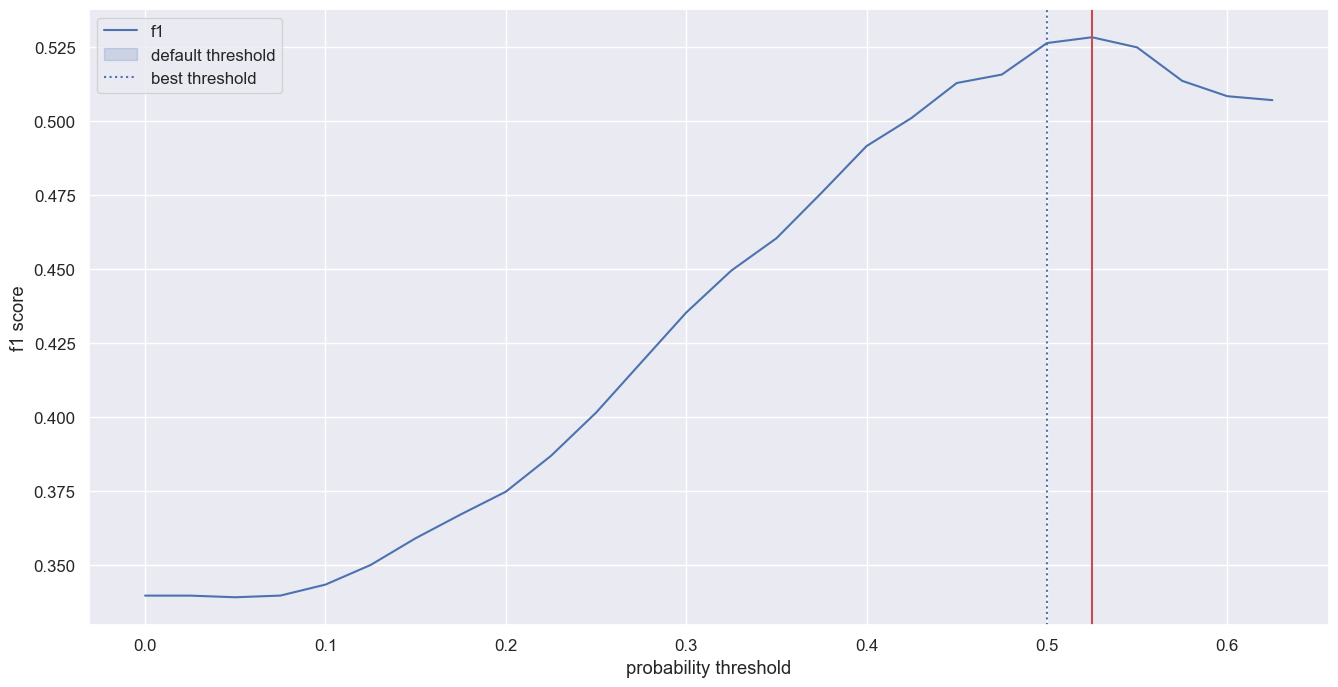

Лучший f1 score 0.528 при пороге 0.525


In [61]:
fig, ax = plt.subplots(figsize=(16, 8))

ax = sns.lineplot(x=logreg_plot_data.keys(), y=logreg_plot_data.values())
best_threshold = max(logreg_plot_data.items(), key=operator.itemgetter(1))

plt.axvline(.5, ls=':')
plt.axvline(best_threshold[0], c='r')
plt.xlabel('probability threshold')
plt.ylabel('f1 score')
plt.legend(['f1', 'default threshold', 'best threshold'])
plt.show()
plt.close()
print(f"Лучший f1 score {best_threshold[1]:.3f} при пороге {best_threshold[0]:.3f}")

##### Decision Tree Classifier

In [62]:
dec_tree_min_leaf = []
dec_tree_depth = []
dec_tree_threshold = []
dec_tree_f1 = []

for leafs in tqdm(range(10, 105, 5)):
    for depth in range(1, 21):
        for threshold in np.arange(0.2, 0.825, 0.025):
            dec_tree_min_leaf.append(leafs)
            dec_tree_depth.append(depth)
            dec_tree_threshold.append(threshold)
            dec_tree_f1.append(model_tune('DecisionTree', X_train=X_train_d, y_train=y_train_d, min_leaf=leafs,
                                          depth=depth, threshold=threshold)['f1_corrected'])

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [03:04<00:00,  9.72s/it]


In [63]:
dec_tree_data_d = pd.DataFrame({'min_leaf': dec_tree_min_leaf, 'depth': dec_tree_depth,
                              'threshold': dec_tree_threshold, 'f1': dec_tree_f1}).sort_values(by='f1', ascending=False)

dec_tree_data_d.head(10).style.apply(lambda x:
                                   ['background-color: orange'] * 4
                                   if x['f1'] == dec_tree_data_d['f1'].max()
                                   else None, axis=1)

,min_leaf,depth,threshold,f1
648,15,6,0.775000,0.611268
148,10,6,0.775000,0.605974
118,10,5,0.650000,0.602436
618,15,5,0.650000,0.602436
172,10,7,0.750000,0.600791
171,10,7,0.725000,0.600791
672,15,7,0.750000,0.593464
671,15,7,0.725000,0.593464
670,15,7,0.700000,0.592965
669,15,7,0.675000,0.592965


##### Random Forest Classifier

In [64]:
rnd_forest_nest = []
rnd_forest_depth = []
rnd_forest_threshold = []
rnd_forest_f1 = []

for nest in tqdm(range(10, 151, 10)):
    for depth in range(1, 21):
        for threshold in np.arange(0.2, 0.825, 0.025):
            rnd_forest_nest.append(nest)
            rnd_forest_depth.append(depth)
            rnd_forest_threshold.append(threshold)
            rnd_forest_f1.append(model_tune('RandomForest', X_train=X_train_d, y_train=y_train_d, nest=nest,
                                          depth=depth, threshold=threshold)['f1_corrected'])

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:04:55<00:00, 259.72s/it]


In [65]:
rnd_forest_data_d = pd.DataFrame({'n_estimators': rnd_forest_nest, 'depth': rnd_forest_depth,
                              'threshold': rnd_forest_threshold, 'f1': rnd_forest_f1}).sort_values(by='f1', ascending=False)

rnd_forest_data_d.head(10).style.apply(lambda x:
                                    ['background-color: orange'] * 4
                                    if x['f1'] == rnd_forest_data_d['f1'].max()
                                    else None, axis=1)

,n_estimators,depth,threshold,f1
6166,130,7,0.600000,0.645858
5167,110,7,0.625000,0.644753
2640,60,6,0.575000,0.643110
6667,140,7,0.625000,0.642948
7167,150,7,0.625000,0.642948
3667,80,7,0.625000,0.641414
6193,130,8,0.650000,0.641361
6141,130,6,0.600000,0.641184
5666,120,7,0.600000,0.641056
4167,90,7,0.625000,0.640506


#### ROC AUC для досэмплированной выборки<a id="3.4"></a>
Дополнительно сравним ROC и подсчитаем площадь под кривыми функций для каждой модели на досэмплированной и недосэмплированной выборках.

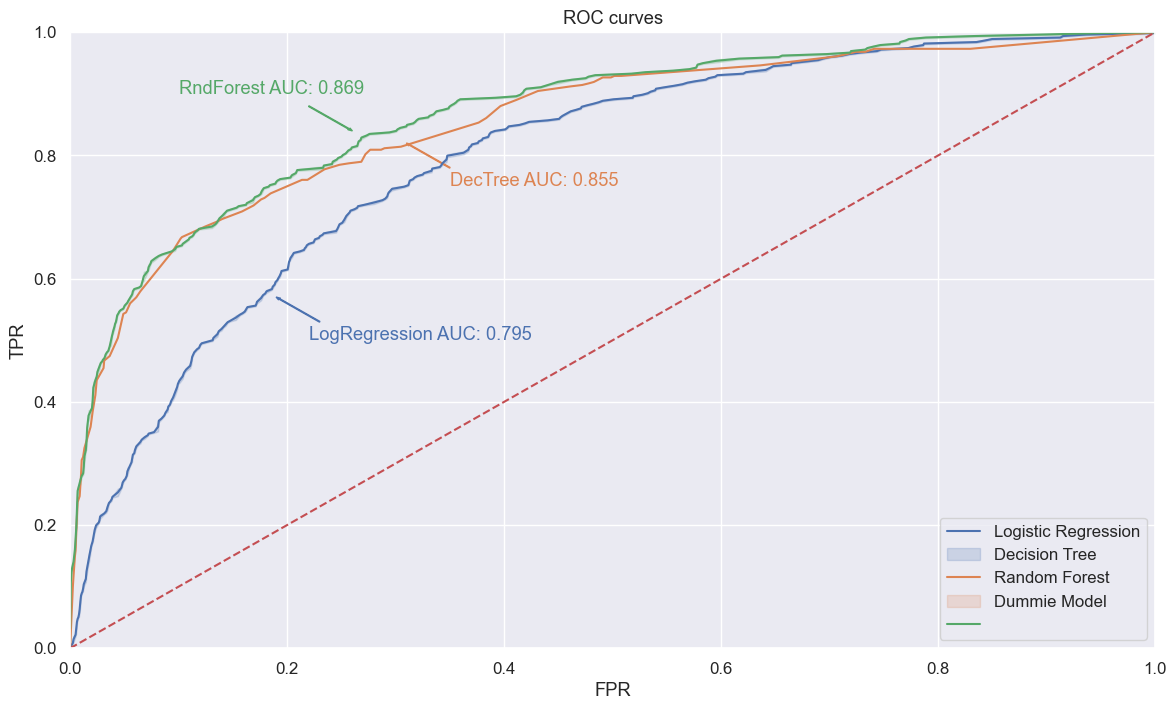

In [70]:
logreg_probabilities = model_tune('LogisticRegression')['probabilities']
dec_tree_probabilities = model_tune('DecisionTree',
                                    min_leaf=dec_tree_data['min_leaf'].head(1).item(),
                                    depth=dec_tree_data['depth'].head(1).item())['probabilities']
rnd_forest_probabilities = model_tune('RandomForest',
                                      nest=rnd_forest_data['n_estimators'].head(1).item(),
                                    depth=rnd_forest_data['depth'].head(1).item())['probabilities']

fpr1, tpr1, thresholds1 = roc_curve(y_val, logreg_probabilities)
fpr2, tpr2, thresholds2 = roc_curve(y_val, dec_tree_probabilities)
fpr3, tpr3, thresholds3 = roc_curve(y_val, rnd_forest_probabilities)

fig, ax = plt.subplots(figsize=(14, 8))

ax1 = sns.lineplot(x=fpr1, y=tpr1)
ax2 = sns.lineplot(x=fpr2, y=tpr2)
ax3 = sns.lineplot(x=fpr3, y=tpr3)
ax4 = sns.lineplot([0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')

plt.legend(['Logistic Regression', 'Decision Tree', 'Random Forest', 'Dummie Model'], loc='lower right')

plt.text(0.22, 0.5, f"LogRegression AUC: {roc_auc_score(y_val, logreg_probabilities):.3f}",
         color=ax.get_lines()[0].get_c())
plt.arrow(0.23, 0.53, -0.037, 0.037, color=ax.get_lines()[0].get_c())

plt.text(0.35, 0.75, f"DecTree AUC: {roc_auc_score(y_val, dec_tree_probabilities):.3f}",
         color=ax.get_lines()[1].get_c())
plt.arrow(0.35, 0.78, -0.037, 0.037, color=ax.get_lines()[1].get_c())

plt.text(0.1, 0.9, f"RndForest AUC: {roc_auc_score(y_val, rnd_forest_probabilities):.3f}",
         color=ax.get_lines()[2].get_c())
plt.arrow(0.22, 0.88, 0.037, -0.037, color=ax.get_lines()[2].get_c())

plt.show()
plt.close()

#### ROC AUC для недосэмплированной выборки

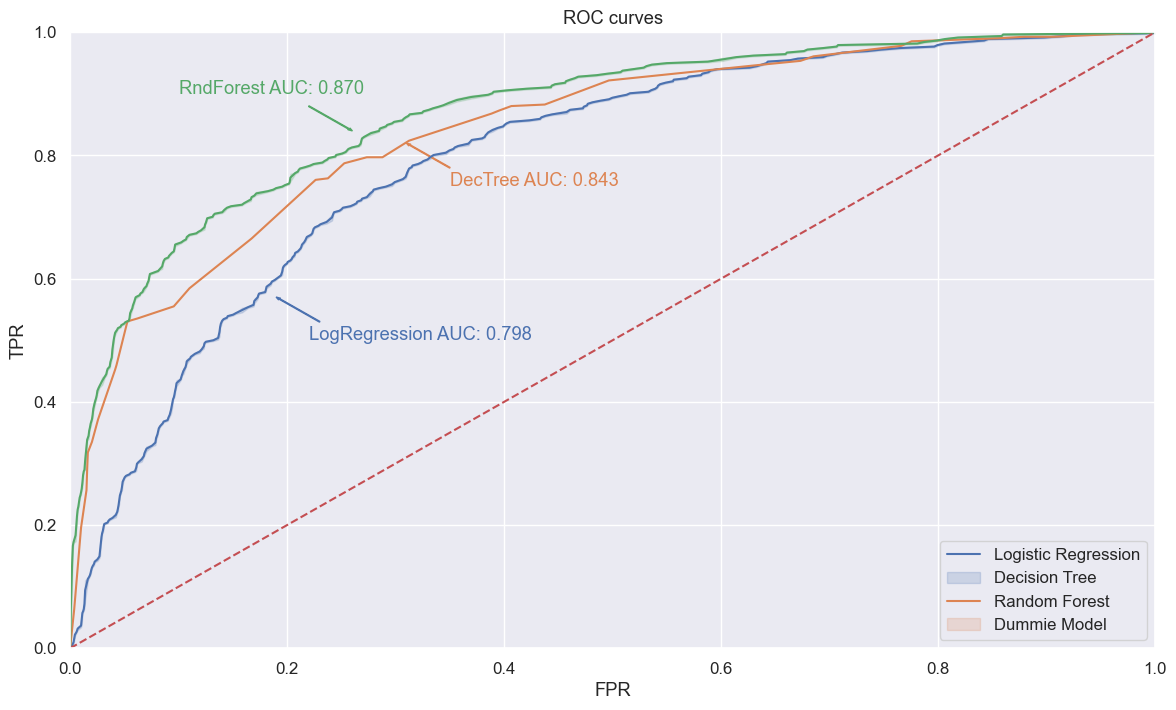

In [72]:
logreg_probabilities = model_tune('LogisticRegression', X_train=X_train_d, y_train=y_train_d)['probabilities']
dec_tree_probabilities = model_tune('DecisionTree',  X_train=X_train_d, y_train=y_train_d,
                                    min_leaf=dec_tree_data_d['min_leaf'].head(1).item(),
                                    depth=dec_tree_data_d['depth'].head(1).item())['probabilities']
rnd_forest_probabilities = model_tune('RandomForest',  X_train=X_train_d, y_train=y_train_d,
                                      nest=rnd_forest_data_d['n_estimators'].head(1).item(),
                                    depth=rnd_forest_data_d['depth'].head(1).item())['probabilities']

fpr1, tpr1, thresholds1 = roc_curve(y_val, logreg_probabilities)
fpr2, tpr2, thresholds2 = roc_curve(y_val, dec_tree_probabilities)
fpr3, tpr3, thresholds3 = roc_curve(y_val, rnd_forest_probabilities)

fig, ax = plt.subplots(figsize=(14, 8))

ax1 = sns.lineplot(x=fpr1, y=tpr1)
ax2 = sns.lineplot(x=fpr2, y=tpr2)
ax3 = sns.lineplot(x=fpr3, y=tpr3)
ax4 = sns.lineplot([0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')

plt.legend(['Logistic Regression', 'Decision Tree', 'Random Forest', 'Dummie Model'], loc='lower right')

plt.text(0.22, 0.5, f"LogRegression AUC: {roc_auc_score(y_val, logreg_probabilities):.3f}",
         color=ax.get_lines()[0].get_c())
plt.arrow(0.23, 0.53, -0.037, 0.037, color=ax.get_lines()[0].get_c())

plt.text(0.35, 0.75, f"DecTree AUC: {roc_auc_score(y_val, dec_tree_probabilities):.3f}",
         color=ax.get_lines()[1].get_c())
plt.arrow(0.35, 0.78, -0.037, 0.037, color=ax.get_lines()[1].get_c())

plt.text(0.1, 0.9, f"RndForest AUC: {roc_auc_score(y_val, rnd_forest_probabilities):.3f}",
         color=ax.get_lines()[2].get_c())
plt.arrow(0.22, 0.88, 0.037, -0.037, color=ax.get_lines()[2].get_c())

plt.show()
plt.close()

Модели `DecisionTreeClassifier` и `RandomForestClassifier` с лучшими подобранными гиперпараметрами имеют схожий коэфициент ROC. Однако, Decision Tree уступает при понижении порога принятия положительного класса за счёт более быстрого роста количества ложно-позитивных ответов.  

Основываясь на результатах проверки ROC и f1 выберем для дальнейшей работы модель `RandomForestClassifier`, обученную на upsamplied выборке.



- [К оглавлению](#0)    

### Тестирование<a id="4"></a>
Проверим результат работы модели случайного леса с выбранными гиперпараметрами на тестовой выборке.

In [74]:
test_results = model_tune( model='RandomForest', X=X_test, y=y_test,
                           nest=rnd_forest_data['n_estimators'].head(1).item(),
                           depth=rnd_forest_data['depth'].head(1).item(),
                           threshold=rnd_forest_data['threshold'].head(1).item() )

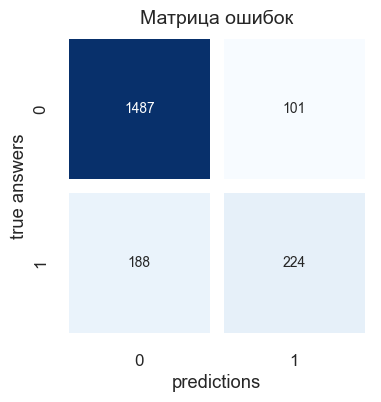

In [75]:
plt.figure(figsize=(4, 4))

ax = sns.heatmap(confusion_matrix(y_test, test_results['corrected_predictions']),
                 linewidths=10, annot=True, 
                 annot_kws={'size': 10}, fmt='.0f', cbar=False, cmap=c)

ax.set(xlabel='predictions', ylabel='true answers')

plt.title('Матрица ошибок', fontsize=14)
plt.show()
plt.close()

На тестовой подвыборке модель верно выявила 224 объекта положительного класса, 101 объект классифицирован ошибочно, 188 положительных объектов не выявлены.

In [76]:
print(classification_report(y_test, test_results['corrected_predictions']))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1588
           1       0.69      0.54      0.61       412

    accuracy                           0.86      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



Таким образом, полнота предсказаний положительного класса составляет **0.54**, точность - **0.69**. Сводная метрика f1 - **0,61**, что выше минимального целевого уровня. 

### Заключение<a id="5"></a>
Мы выбрали, подготовили и протестировали модель прогнозирования оттока клиентов банка, которая даёт прогноз с точностью и полнотой свыше 60%. При необходимости снизить количество ложных положительных ответов, порог принятия класса можно повысить. При необходимости сместить баланс в пользу максимально выозможной выявляемости положительных ответов порог, напротив, можно понизить.    


- [К оглавлению](#0)      